## Recursive Least Squares (RLS) Estimation

The **Recursive Least Squares (RLS)** algorithm is a powerful tool used in signal processing and control theory to estimate the parameters of a system in real-time. Unlike batch methods that require an entire dataset at once, RLS updates its estimate each time a new piece of data arrives. This makes it highly efficient for online applications.

Let's break down how the algorithm works by mapping its core mathematical steps to a practical Python example. The goal in our example is simple: to find a single true value (`x`) based on a series of noisy measurements.

---

### **Step 1: Initialization** ⚙️

Every estimation journey needs a starting point. The RLS algorithm begins by defining an initial guess and our confidence in that guess.

#### **The Theory**
We must define two initial parameters:
1.  **Initial State Estimate ($\hat{x}_0$)**: Our best first guess of the true value, represented as $E(x)$.
2.  **Initial Error Covariance ($P_0$)**: Our uncertainty about that initial guess, represented as $E[(x - \hat{x}_0)(x - \hat{x}_0)^T]$. A large $P_0$ means we have low confidence, while a small $P_0$ means we're very confident.

#### **The Practice (Python)**
In our code, we assume we know nothing about the true value (which is secretly `4.2`).
* We set our initial guess, **`x_hat_0`**, to zero, a neutral starting point.
    ```python
    x_hat_0 = np.array([[0.0]])
    ```
* We set our initial covariance, **`P_0`**, to a large value to signify high uncertainty.
    ```python
    P_0 = np.array([[100.0]])
    ```

---

### **Step 2: The Recursive Loop** 🔄

This is the heart of the algorithm. For each new measurement, we perform a cycle of obtaining data and updating our estimate.

### **Part A: The Measurement Model**

First, we need to understand the relationship between the true value we're seeking and the measurements we can actually observe.

#### **The Theory**
The measurement $y_k$ at time step `k` is related to the true state `x` by the equation: $y_k = H_k x + v_k$ Here, $H_k$ is the **measurement matrix** that describes how `x` is observed, and $v_k$ is the unavoidable **measurement noise**.

#### **The Practice (Python)**
In our example script:
* The true state **`x_true`** is `4.2`.
* The measurement matrix **`H_rls`** is `1.0` because we are measuring the state directly.
* The measurement noise is defined by its covariance **`R`**, which is set to `100.0` (from a standard deviation of `10.0`). The code generates a series of noisy measurements based on this model.
    ```python
    # The model used to generate our data
    measurements = (H_rls @ x_true).item() + noise
    ```

### **Part B: The Update Equations**

With a new measurement in hand, we can now refine our estimate and reduce our uncertainty.

#### **The Theory**
The update happens in three key calculations:

1.  **Optimal Gain Matrix ($K_k$)**: This critical value determines how much we trust the new measurement versus our existing estimate. It's calculated as:
    $$K_k = P_{k-1}H_k^T(H_kP_{k-1}H_k^T + R_k)^{-1}$$
2.  **State Estimate Update ($\hat{x}_k$)**: The new estimate is the old estimate plus a correction term. The correction is the Optimal Gain Matrix multiplied by the "surprise" the difference between the actual and predicted measurement.

    $\hat{x}_k$
        
    $= \hat{x}_{k-1} + $
    
    $K_k(y_k - H_k\hat{x}_{k-1})$

3.  **Covariance Update ($P_k$)**: We update our uncertainty. Having incorporated new information, our uncertainty should decrease. The equation is:
    $$P_k = (I - K_kH_k)P_{k-1}(I - K_kH_k)^T + K_kR_kK_k^T$$

#### **The Practice (Python)**
Our Python code implements these three equations directly inside its `for` loop:
```python
# 1. Calculate Optimal Gain Matrix
K_k = P_k_minus_1 @ H.T @ np.linalg.inv(H @ P_k_minus_1 @ H.T + R)

# 2. Update state estimate
x_hat_k = x_hat_k_minus_1 + K_k @ (y_k - H @ x_hat_k_minus_1)

# 3. Update covariance (using the stable Joseph form)
term_joseph = I - K_k @ H
P_k = term_joseph @ P_k_minus_1 @ term_joseph.T + K_k @ R @ K_k.T
```

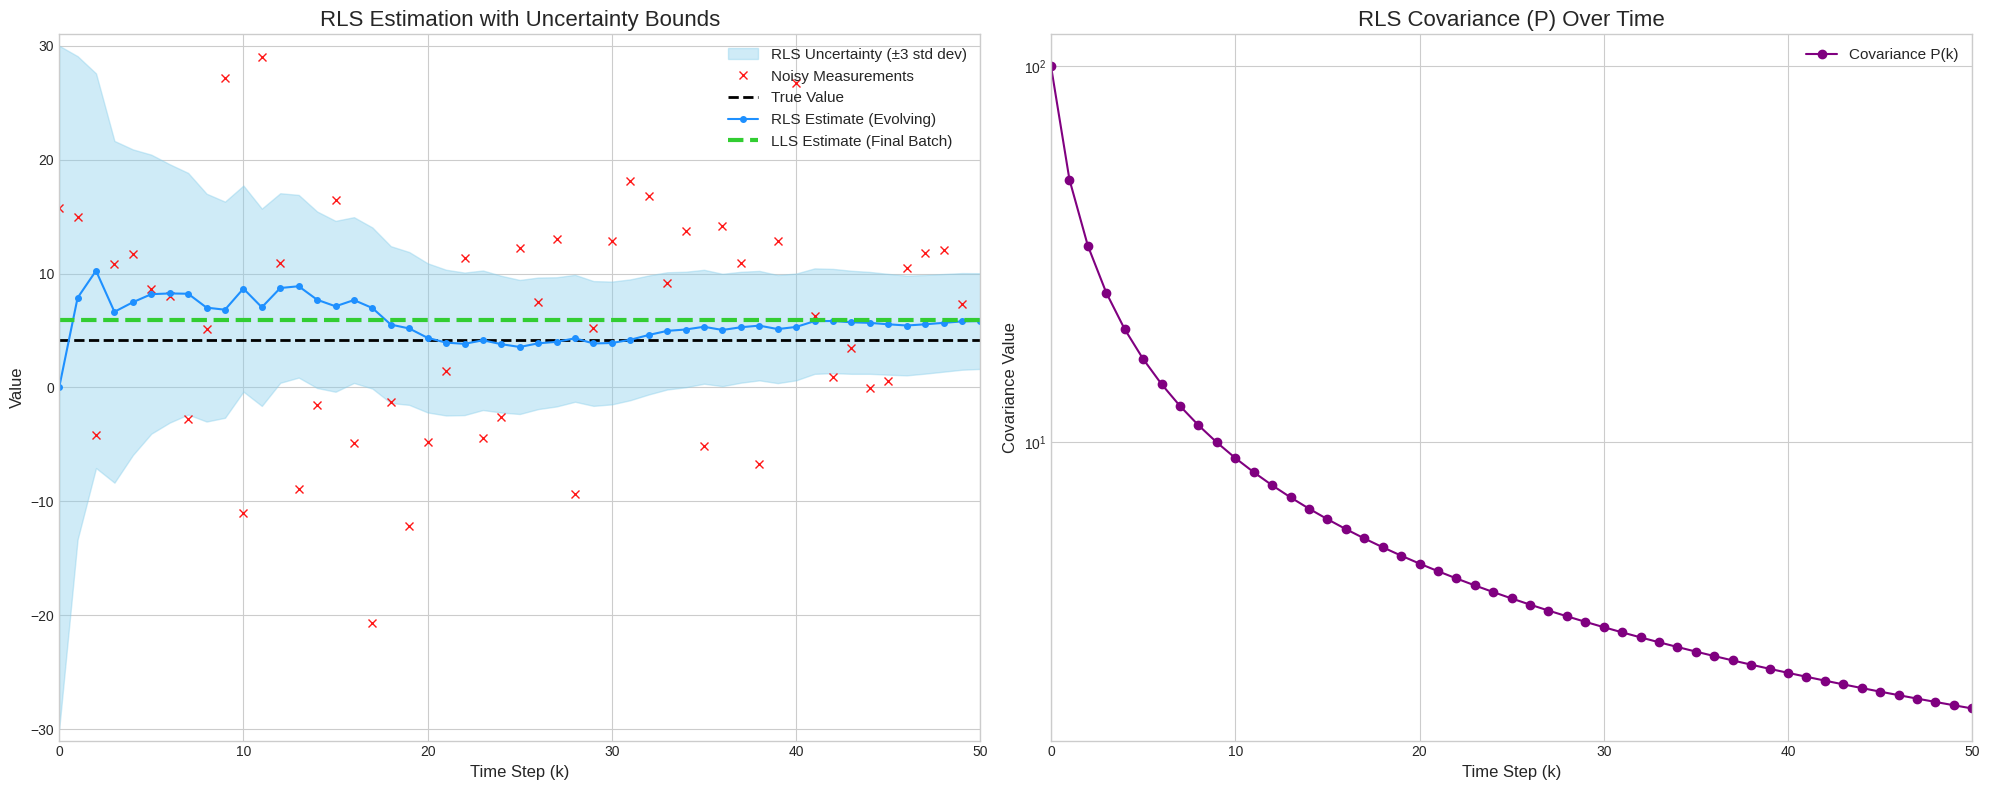

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rls_estimator(measurements, H, R, x_hat_0, P_0):
    """
    Implements the Recursive Least Squares (RLS) algorithm.

    Args:
        measurements (np.array): A vector of sequential measurements (y_k).
        H (np.array): The measurement matrix.
        R (np.array): The measurement noise covariance matrix.
        x_hat_0 (np.array): The initial state estimate.
        P_0 (np.array): The initial error covariance matrix.

    Returns:
        x_hat_list (list): The history of state estimates.
        P_list (list): The history of the error covariance matrices.
    """
    # Get the number of time steps and the dimension of the state
    n_steps = len(measurements)
    n_dim = x_hat_0.shape[0]

    # Initialize lists to store the history of estimates and covariances
    x_hat_list = [x_hat_0]
    P_list = [P_0]

    # Get the identity matrix for later use
    I = np.identity(n_dim)

    # Initialize the current state and covariance
    x_hat_k = x_hat_0
    P_k = P_0

    # --- Recursive Loop ---
    for k in range(n_steps):
        # The previous state and covariance
        x_hat_k_minus_1 = x_hat_k
        P_k_minus_1 = P_k

        # Get the current measurement
        y_k = measurements[k].reshape(1, 1)

        # 1. Compute the Kalman Gain (K_k)
        term1 = P_k_minus_1 @ H.T
        term2 = np.linalg.inv(H @ P_k_minus_1 @ H.T + R)
        K_k = term1 @ term2

        # 2. Update the Estimate (x̂_k)
        correction = y_k - H @ x_hat_k_minus_1
        x_hat_k = x_hat_k_minus_1 + K_k @ correction

        # 3. Update the Error Covariance (P_k) using the Joseph Form
        term_joseph = I - K_k @ H
        P_k = term_joseph @ P_k_minus_1 @ term_joseph.T + K_k @ R @ K_k.T

        # Store the results
        x_hat_list.append(x_hat_k)
        P_list.append(P_k)

    return x_hat_list, P_list

def linear_least_squares(measurements):
    """
    Performs batch Linear Least Squares using the normal equation.

    Args:
        measurements (np.array): A vector of all available measurements.

    Returns:
        x_hat (np.array): The single, final state estimate.
    """
    # For this problem, H is a column vector of ones, since y_k = 1 * x
    n_samples = len(measurements)
    H_stacked = np.ones((n_samples, 1))

    # The measurements need to be a column vector
    y_stacked = measurements.reshape(-1, 1)

    # Apply the normal equation: x̂ = (HᵀH)⁻¹Hᵀy
    H_transpose_H_inv = np.linalg.inv(H_stacked.T @ H_stacked)
    H_transpose_y = H_stacked.T @ y_stacked
    x_hat = H_transpose_H_inv @ H_transpose_y

    # For this specific problem, this simplifies to just taking the average!
    # print(f"Mean of measurements: {np.mean(measurements):.4f}")

    return x_hat

# --- Example Toy Dataset ---
x_true = np.array([[4.2]])          # The true value we want to estimate
H_rls = np.array([[1.0]])           # Measurement matrix
noise_std_dev = 10.0                # Standard deviation of measurement noise
R = np.array([[noise_std_dev**2]])  # Measurement noise covariance
n_samples = 50                      # Number of measurements

# Generate noisy measurements around the true value
noise = np.random.normal(0, noise_std_dev, n_samples)
measurements = (H_rls @ x_true).item() + noise

# --- Run Both Estimators ---
# Initial guess and initial covariance for RLS
x_hat_0 = np.array([[0.0]])         # Initial guess is 0 but true value is 4.2
P_0 = np.array([[100.0]])           # High initial uncertainty

# Run RLS and LLS
x_estimates_rls, P_covariances_rls = rls_estimator(measurements, H_rls, R, x_hat_0, P_0)
x_estimate_lls = linear_least_squares(measurements)

# --- Prepare data for plotting ---
# Extract scalar values from the matrices/lists for easier plotting
x_est_rls_scalar = np.array([x.item() for x in x_estimates_rls])
P_cov_rls_scalar = np.array([p.item() for p in P_covariances_rls])
x_est_lls_scalar = x_estimate_lls.item()

# Calculate the standard deviation and 3-sigma confidence bounds for the estimate
std_devs = np.sqrt(P_cov_rls_scalar)
upper_bound = x_est_rls_scalar + 3 * std_devs
lower_bound = x_est_rls_scalar - 3 * std_devs

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')

# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT 1: RLS Estimation and Uncertainty (on the left axis, ax1) ---
ax1.set_title('RLS Estimation with Uncertainty Bounds', fontsize=16)

# Plot the uncertainty bounds as a shaded region
ax1.fill_between(
    range(n_samples + 1),
    lower_bound,
    upper_bound,
    color='skyblue',
    alpha=0.4,
    label='RLS Uncertainty (±3 std dev)'
)

# Plot the measurements and true value
ax1.plot(measurements, 'x', color='red', label='Noisy Measurements', alpha=0.9)
ax1.axhline(y=x_true.item(), color='k', linestyle='--', linewidth=2, label='True Value')

# Plot the RLS and LLS estimates
ax1.plot(x_est_rls_scalar, 'o-', color='dodgerblue', markersize=4, label='RLS Estimate (Evolving)')
ax1.axhline(y=x_est_lls_scalar, color='limegreen', linestyle='--', linewidth=3, label='LLS Estimate (Final Batch)')

# Final plot formatting for ax1
ax1.set_xlabel('Time Step (k)', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True)
ax1.set_ylim(min(measurements.min(), lower_bound.min())-1, max(measurements.max(), upper_bound.max())+1)
ax1.set_xlim(0, n_samples)


# --- PLOT 2: Covariance Drop Over Time (on the right axis, ax2) ---
ax2.set_title('RLS Covariance (P) Over Time', fontsize=16)

# Plot the covariance data
ax2.plot(range(n_samples + 1), P_cov_rls_scalar, 'o-', color='purple', label='Covariance P(k)')

# Plot formatting for ax2
ax2.set_xlabel('Time Step (k)', fontsize=12)
ax2.set_ylabel('Covariance Value', fontsize=12)
ax2.set_yscale('log') # Use a log scale to better see the initial rapid drop
ax2.legend(fontsize=11)
ax2.grid(True)
ax2.set_xlim(0, n_samples)

# Adjust layout to prevent titles/labels from overlapping and show the plot
plt.tight_layout()
plt.show()

--- Computational Time Analysis ---
Average RLS time per step: 69.58 microseconds
Average Batch LLS time per step: 211.89 microseconds
Final RLS time: 118.51 microseconds
Final LLS time (with all 50000 data points): 290.65 microseconds


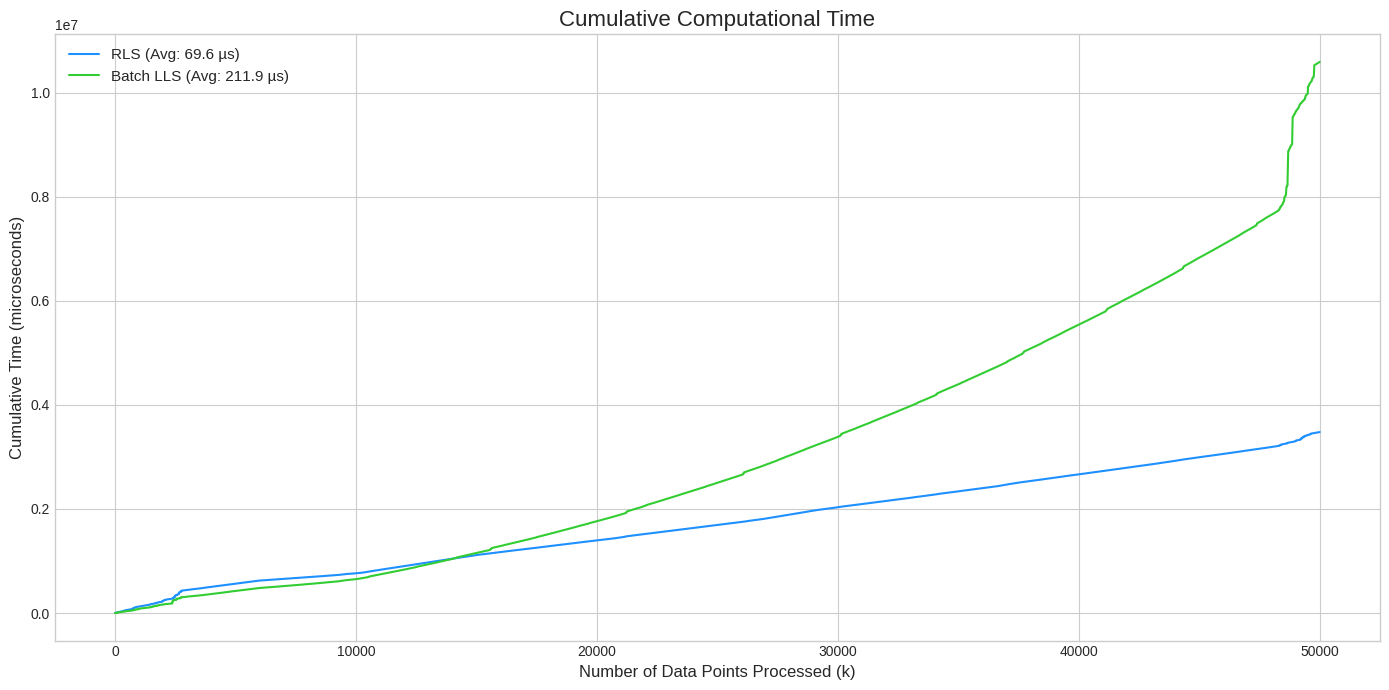

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- RLS Function (Single Step Update) ---
def rls_single_step(x_hat_prev, P_prev, y_k, H, R):
    """Performs a single update step of the RLS algorithm."""
    I = np.identity(x_hat_prev.shape[0])

    K_k = P_prev @ H.T @ np.linalg.inv(H @ P_prev @ H.T + R)
    x_hat_k = x_hat_prev + K_k @ (y_k - H @ x_hat_prev)

    term_joseph = I - K_k @ H
    P_k = term_joseph @ P_prev @ term_joseph.T + K_k @ R @ K_k.T

    return x_hat_k, P_k

# --- Batch LLS Function (from previous example) ---
def linear_least_squares(measurements):
    """Performs batch Linear Least Squares using the normal equation."""
    n_samples = len(measurements)
    H_stacked = np.ones((n_samples, 1))
    y_stacked = measurements.reshape(-1, 1)

    # Normal equation: x̂ = (HᵀH)⁻¹Hᵀy
    x_hat = np.linalg.inv(H_stacked.T @ H_stacked) @ H_stacked.T @ y_stacked
    return x_hat

# --- Simulation Setup ---
x_true = np.array([[4.2]])
H = np.array([[1.0]])
noise_std_dev = 2.0
R = np.array([[noise_std_dev**2]])
n_samples = 50000 # Using more samples to better see the time trend
noise = np.random.normal(0, noise_std_dev, n_samples)
measurements = (H @ x_true).item() + noise

# --- Initialization ---
x_hat_0 = np.array([[0.0]])
P_0 = np.array([[100.0]])

# Lists to store results
rls_times = []
lls_times = []
rls_estimates = [x_hat_0]
lls_estimates = [] # LLS estimate doesn't exist at time 0

# --- Main Simulation Loop ---
x_hat_k_rls, P_k_rls = x_hat_0, P_0

for k in range(1, n_samples + 1):
    # Get the current data point and the cumulative data so far
    current_measurement = measurements[k-1]
    cumulative_measurements = measurements[:k]

    # --- Time the RLS update ---
    start_time = time.perf_counter()
    x_hat_k_rls, P_k_rls = rls_single_step(x_hat_k_rls, P_k_rls, current_measurement, H, R)
    end_time = time.perf_counter()
    rls_times.append((end_time - start_time) * 1e6) # Store time in microseconds

    # --- Time the Batch LLS recalculation ---
    start_time = time.perf_counter()
    x_hat_k_lls = linear_least_squares(cumulative_measurements)
    end_time = time.perf_counter()
    lls_times.append((end_time - start_time) * 1e6) # Store time in microseconds

    # Store estimates
    rls_estimates.append(x_hat_k_rls)
    lls_estimates.append(x_hat_k_lls)

# --- Print Final Results ---
print("--- Computational Time Analysis ---")
print(f"Average RLS time per step: {np.mean(rls_times):.2f} microseconds")
print(f"Average Batch LLS time per step: {np.mean(lls_times):.2f} microseconds")
print(f"Final RLS time: {rls_times[-1]:.2f} microseconds")
print(f"Final LLS time (with all {n_samples} data points): {lls_times[-1]:.2f} microseconds")


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot: Time Complexity Comparison
ax.plot(np.cumsum(rls_times), color='dodgerblue', label=f'RLS (Avg: {np.mean(rls_times):.1f} µs)')
ax.plot(np.cumsum(lls_times), color='limegreen', label=f'Batch LLS (Avg: {np.mean(lls_times):.1f} µs)')
ax.set_title('Cumulative Computational Time', fontsize=16)
ax.set_xlabel('Number of Data Points Processed (k)', fontsize=12)
ax.set_ylabel('Cumulative Time (microseconds)', fontsize=12) # Corrected label
ax.legend(fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()